### 데이터 불러오기

In [1]:
import pandas as pd
from ast import literal_eval

In [38]:
df_train = pd.read_csv('../resources/raw/train_reformat.csv')
df_train_s = pd.read_csv('../resources/processed/train_reformat_with_source_subject.csv', index_col=0)
df_test = pd.read_csv('../resources/raw/test_reformat.csv')

In [12]:
df_train['choices'] = [
        "\n".join([f"{idx + 1} - {choice.strip()}" for idx, choice in enumerate(literal_eval(x))])
        for x in df_train["choices"]
    ]

In [39]:
df_train_s['choices'] = [
        "\n".join([f"{idx + 1} - {choice.strip()}" for idx, choice in enumerate(literal_eval(x))])
        for x in df_train_s["choices"]
    ]

In [14]:
df_test['choices'] = [
        "\n".join([f"{idx + 1} - {choice.strip()}" for idx, choice in enumerate(literal_eval(x))])
        for x in df_test["choices"]
    ]

In [16]:
df_train_s['source'].value_counts()

source
KLUE-MRC    1239
MMMLU        719
KMMLU         72
Name: count, dtype: int64

### paragraph 정보량 확인

In [40]:
from transformers import AutoTokenizer

In [41]:
tokenizer = AutoTokenizer.from_pretrained("beomi/Qwen2.5-7B-Instruct-kowiki-qa-context", trust_remote_code=True)

In [20]:
df_train['paragraph_len'] = [len(tokenizer.tokenize(x)) for x in df_train['paragraph']]

In [21]:
df_train['paragraph_len'].describe()

count    2030.000000
mean      532.231527
std       342.766949
min         8.000000
25%       277.250000
50%       507.000000
75%       743.750000
max      1508.000000
Name: paragraph_len, dtype: float64

<Axes: >

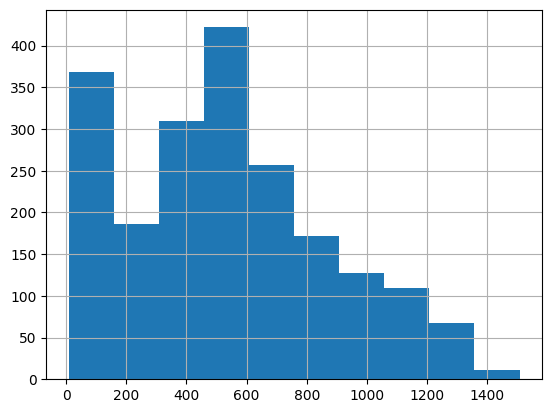

In [36]:
df_train['paragraph_len'].hist()

In [31]:
df_test['paragraph_len'] = [len(tokenizer.tokenize(x)) for x in df_test['paragraph']]

In [35]:
df_test['paragraph_len'].describe()

count     869.000000
mean      635.850403
std       527.426624
min        11.000000
25%       206.000000
50%       499.000000
75%       874.000000
max      2076.000000
Name: paragraph_len, dtype: float64

<Axes: >

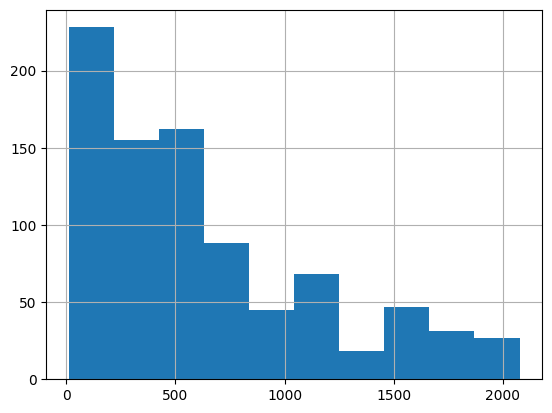

In [37]:
df_test['paragraph_len'].hist()

In [42]:
df_train_s['paragraph_len'] = [len(tokenizer.tokenize(x)) for x in df_train_s['paragraph']]

In [43]:
df_train_s.to_csv('check.csv', index=0, encoding='utf-8-sig')

In [25]:
df_train_s['source'].value_counts()

source
KLUE-MRC    1239
MMMLU        719
KMMLU         72
Name: count, dtype: int64

<Axes: >

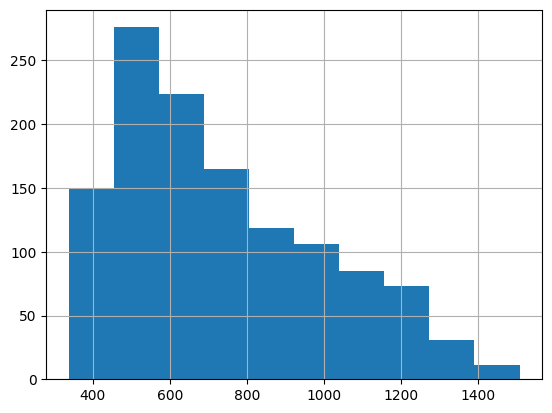

In [27]:
df_train_s[df_train_s['source'] == "KLUE-MRC"]['paragraph_len'].hist()

<Axes: >

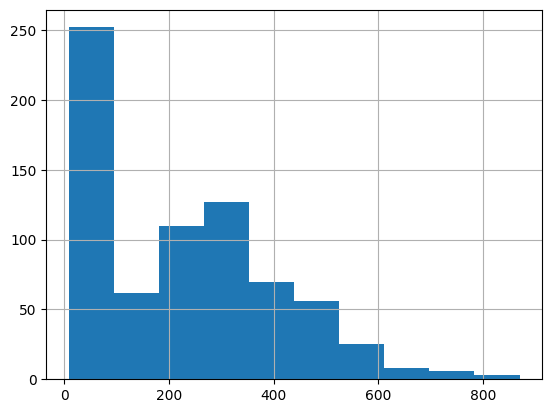

In [28]:
df_train_s[df_train_s['source'] == "MMMLU"]['paragraph_len'].hist()

<Axes: >

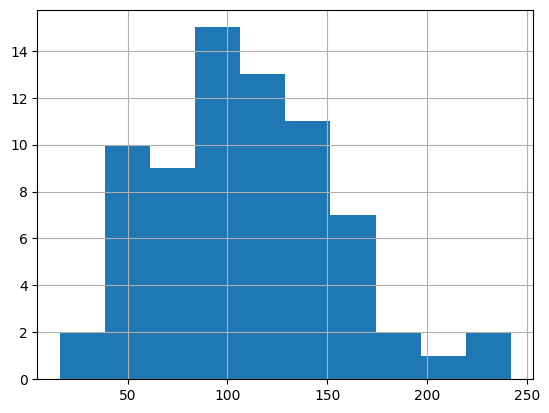

In [29]:
df_train_s[df_train_s['source'] == "KMMLU"]['paragraph_len'].hist()

### Source 종류에 따른 retireval
- KLUE-MRC에 속하는 모든 데이터는 주어진 지문에서 정답을 찾을 수 있어 제외
- KMMLU에 속하는 모든 데이터읨 질문은 "다음 정책을 시행한 국왕의 재위 기간에 있었던 사실로 옳은 것은?" 형식과 유사, 질문으로 관련된 문서를 찾기는 힘들 것 같아 "paragraph"와 관련된 문서 찾기
- MMMLU는 특이함 : 편의상 "질문"과 "paragraph" 모두 이용하여 retrieval 진행
    - economics : paragraph가 선택형인 경우(달러 가치 vs 미국 수출)와 사전 지식을 기반으로 대답해야 하는 경우(총 공급 곡선이 왼쪽으로 이동하면 균형 가격 수준과 균형 생산량은 어떻게 됩니까?")가 대다수
        - 이에, "질문"과 관련된 문서를 찾기로 결정
        - 그런데, "이 정보에 기초하여," 처럼 필요 없는 경우도 있고, "이는 어떤 유형의 실업입니까?"의 정답의 정보가 필요한 경우가 있어 완벽하지 않음
    - european_history : 마찬가지로 "이 조약의 시발점은 무엇이었습니까?"와 같이 질문으로 관련된 문서를 찾기 어려운 경우도 존재하고, "다음 중 루이 14세 통치의 가장 큰 약점이자 유감스러운 점은 무엇이었습니까?"라는 질문으로 연결된 paragraph가 전혀 상관 없는 내용인 경우가 있음. 따라서, "질문"과 "paragraph" 둘다 이용 해야하는 상황
    - "루이 14세는 유능한 조언자의 도움을 많이 받았는데, 다음 중 그가 프랑스를 재편하고 열강으로 만드는 데 도움을 준 조언자는 누구였습니까?"
    - government_and_politics: 위와 비슷한 상황으로 "질문"과 "paragraph" 둘 다 이용해야 함 / deduplicated 해야함
    - government_and_politics: 위와 비슷한 상황으로 "질문"과 "paragraph" 둘 다 이용해야 함 / deduplicated 해야함
    - us_history : 위와 비슷한 상황으로 "질문"과 "paragraph" 둘 다 이용해야 함
    - word_history : 위와 비슷한 상황으로 "질문"과 "paragraph" 둘 다 이용해야 함

In [1]:
try: import torch
except: raise ImportError('Install torch via `pip install torch`')
from packaging.version import Version as V
v = V(torch.__version__)
cuda = str(torch.version.cuda)
is_ampere = torch.cuda.get_device_capability()[0] >= 8
if cuda != "12.1" and cuda != "11.8" and cuda != "12.4": raise RuntimeError(f"CUDA = {cuda} not supported!")
if   v <= V('2.1.0'): raise RuntimeError(f"Torch = {v} too old!")
elif v <= V('2.1.1'): x = 'cu{}{}-torch211'
elif v <= V('2.1.2'): x = 'cu{}{}-torch212'
elif v  < V('2.3.0'): x = 'cu{}{}-torch220'
elif v  < V('2.4.0'): x = 'cu{}{}-torch230'
elif v  < V('2.5.0'): x = 'cu{}{}-torch240'
elif v  < V('2.6.0'): x = 'cu{}{}-torch250'
else: raise RuntimeError(f"Torch = {v} too new!")
x = x.format(cuda.replace(".", ""), "-ampere" if is_ampere else "")
print(f'pip install --upgrade pip && pip install "unsloth[{x}] @ git+https://github.com/unslothai/unsloth.git"')

pip install --upgrade pip && pip install "unsloth[cu124-torch250] @ git+https://github.com/unslothai/unsloth.git"
